In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# pd.set_option("display.height", 500)
pd.set_option("display.max_rows", 500)

In [2]:
parcels = gpd.read_file("../data/Parcels_1/Parcels_1.shp")
# parcels = gpd.read_file("../data/Durham_Tax_Parcels.gdb")
active_addresses = gpd.read_file("../data/ActiveAdresses.gdb")
parcels.head()

,OBJECTID_1,OBJECTID,FEATURE_KE,PARCEL_TYP,REID,PARCEL_PK,AUT_SNAPSH,PIN,PIN_EXT,PIN_MAP,...,MAP_ROD_DO,IS_PENDING,GROSS_LEAS,PLAT_BOOK,PLAT_PAGE,PHOTO_PATH,PHOTO_DATE,Shape__Are,Shape__Len,geometry
0,5293332,78584,78587,0,100000,1,2021-12-20,0822419440,000,0822,...,None,N,0,000000,000000,None,None,4.241395e+06,8814.872258,"MULTIPOLYGON (((-78.91250 36.00508, -78.91253 ..."
1,5293333,18719,18719,0,100001,2,2021-12-20,0822537639,000,0822,...,None,N,0,00005A,000041,None,None,6.934546e+03,376.739897,"POLYGON ((-78.91321 36.01309, -78.91320 36.013..."
2,5293334,18271,18271,0,100002,3,2021-12-20,0822537634,000,0822,...,None,N,0,00005A,000041,None,None,6.917429e+03,376.639565,"POLYGON ((-78.91274 36.01307, -78.91275 36.012..."
3,5293335,18958,18958,0,100003,4,2021-12-20,0822537539,000,0822,...,None,N,0,00005A,000043,None,None,6.927336e+03,377.025220,"POLYGON ((-78.91275 36.01293, -78.91276 36.012..."
4,5293336,17297,17297,0,100004,5,2021-12-20,0822537534,000,0822,...,None,N,0,00005A,000043,None,None,6.945440e+03,377.529386,"POLYGON ((-78.91276 36.01280, -78.91276 36.012..."


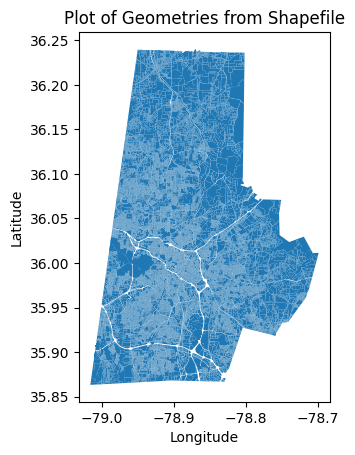

In [3]:
# Plot the GeoDataFrame
parcels.plot()
plt.title("Plot of Geometries from Shapefile")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

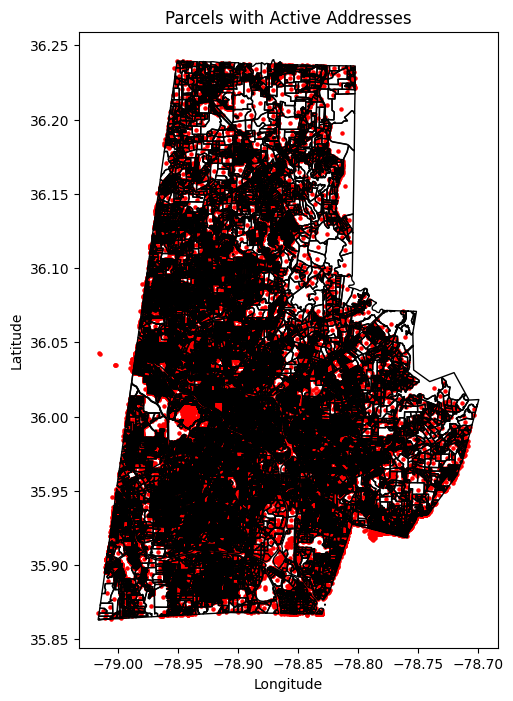

In [4]:
if parcels.crs != active_addresses.crs:
    active_addresses = active_addresses.to_crs(parcels.crs)

# Perform the spatial join
joined_gdf = gpd.sjoin(active_addresses, parcels, how="left", predicate="within")

# Plot the parcels and addresses
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
parcels.boundary.plot(ax=ax, linewidth=1, color="black")
active_addresses.plot(ax=ax, marker="o", color="red", markersize=5)
plt.title("Parcels with Active Addresses")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Zoom in on a parcel with multiple adresses

In [5]:
# Filter the GeoDataFrames to include only the target parcel and its addresses
target_parcel = parcels.query("OBJECTID == 88397")
target_addresses = joined_gdf.query("OBJECTID == 88397")

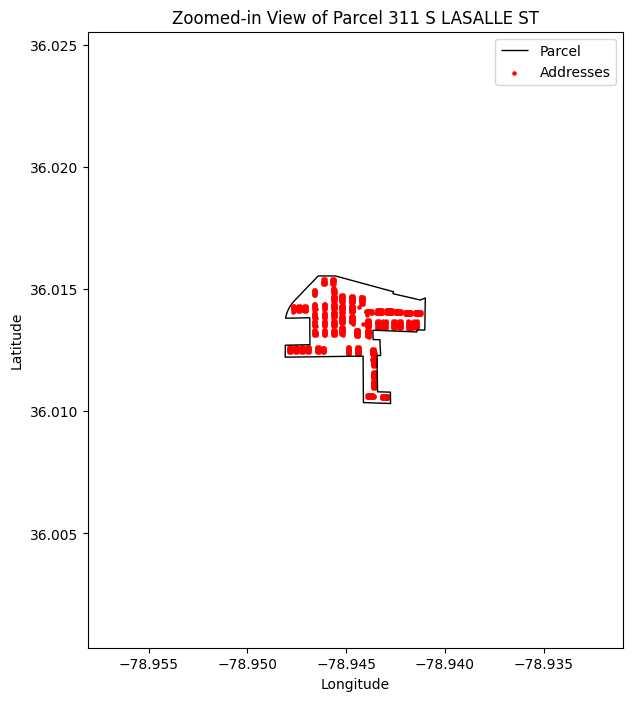

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

target_parcel.boundary.plot(ax=ax, linewidth=1, color="black", label="Parcel")
target_addresses.plot(ax=ax, marker="o", color="red", markersize=5, label="Addresses")

# Set plot title and labels
plt.title(f'Zoomed-in View of Parcel {target_parcel["LOCATION_A"].values[0]}')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Zoom in on the parcel by setting the axis limits to the parcel's bounds
parcel_bounds = target_parcel.total_bounds
ax.set_xlim(parcel_bounds[0] - 0.01, parcel_bounds[2] + 0.01)
ax.set_ylim(parcel_bounds[1] - 0.01, parcel_bounds[3] + 0.01)

plt.show()

## Adress counts by Parcel

In [ ]:
# Count the number of addresses per parcel
address_counts = (
    joined_gdf.groupby("index_right").size().reset_index(name="address_count")
)

# Merge the address counts back into the parcels GeoDataFrame
parcels_with_counts = parcels.join(address_counts.set_index("index_right"), how="left")

# Fill NaN values with 0 (parcels with no addresses)
parcels_with_counts["address_count"] = parcels_with_counts["address_count"].fillna(0)

# Plot the parcels colored by the number of addresses
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
parcels_with_counts.plot(
    column="address_count",
    ax=ax,
    legend=True,
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
)
plt.title("Parcels Colored by Number of Addresses")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [10]:
parcels_with_counts.to_csv("parcel_address_counts.csv")

In [13]:
# Merge Dwelling Unit csv to parcels_res

ResParcelsDU = pd.read_csv("../data/ResParcelsDU.csv")
ResParcelsDU = ResParcelsDU.copy()
ResParcelsDU['REID'] = ResParcelsDU['REID'].astype(str)
parcels_with_counts = parcels_with_counts.copy()
parcels_with_counts['REID'] = parcels_with_counts['REID'].astype(str)

# Merge the address_count from parcels_with_counts into the merged_df
merged_with_counts_df = ResParcelsDU.merge(parcels_with_counts[['REID', 'address_count']], on='REID', how='left')

# Fill missing values in the address_count column with a suitable value, e.g., 0 or 'N/A'
merged_with_counts_df['address_count'] = merged_with_counts_df['address_count'].fillna(0)

merged_with_counts_df.to_csv("ResParcels_DU_addresscounts.csv")


/tmp/ipykernel_33470/3787915782.py:3: DtypeWarning: Columns (19,22,37,40,41,47,65,83,85,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  ResParcelsDU = pd.read_csv("../data/ResParcelsDU.csv")


In [71]:
parcels_with_counts_subset = parcels_with_counts[
    [
        "OBJECTID",
        "LOCATION_A",
        "LAND_CLASS",
        "ACREAGE",
        "PHYADDR_ZI",
        "TOTAL_LAND",
        "TOTAL_BLDG",
        "LAND_USE_V",
        "TOTAL_PROP",
        "COST_TOTAL",
        "NEIGHBORHO",
        "Shape__Are",
        "Shape__Len",
        "geometry",
        "address_count",
    ]
]

In [72]:
parcels_with_counts_subset.loc[:, "average_prop_value"] = (
    parcels_with_counts_subset["TOTAL_PROP"]
    / parcels_with_counts_subset["address_count"]
).round()

/Users/dhavalpotdar/.pyenv/versions/3.10.0/envs/dps/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [73]:
parcels_with_counts_subset

,OBJECTID,LOCATION_A,LAND_CLASS,ACREAGE,PHYADDR_ZI,TOTAL_LAND,TOTAL_BLDG,LAND_USE_V,TOTAL_PROP,COST_TOTAL,NEIGHBORHO,Shape__Are,Shape__Len,geometry,address_count,average_prop_value
0.0,78584,1500 W MAIN ST,CMNTY SVC/ COLLEGE,97.24,27705,29471700.0,0.0,29471700.0,29471700.0,29471700.0,W PETTIGREW ST,4.241395e+06,8814.872258,"MULTIPOLYGON (((-78.91250 36.00508, -78.91253 ...",50.0,589434.0
1.0,18719,922 LANCASTER ST,RES/ 2-FAMILY,0.16,27701,115900.0,45120.0,115900.0,161020.0,161020.0,WALL TOWN,6.934546e+03,376.739897,"POLYGON ((-78.91321 36.01309, -78.91320 36.013...",3.0,53673.0
2.0,18271,920 LANCASTER ST,RES/ 2-FAMILY,0.16,27701,115900.0,64657.0,115900.0,180557.0,180557.0,WALL TOWN,6.917429e+03,376.639565,"POLYGON ((-78.91274 36.01307, -78.91275 36.012...",3.0,60186.0
3.0,18958,918 LANCASTER ST,RES/ 2-FAMILY,0.16,27701,115900.0,51287.0,115900.0,167187.0,167187.0,WALL TOWN,6.927336e+03,377.025220,"POLYGON ((-78.91275 36.01293, -78.91276 36.012...",3.0,55729.0
4.0,17297,916 LANCASTER ST,RES/ 1-FAMILY,0.16,27701,115900.0,554155.0,115900.0,670055.0,670055.0,WALL TOWN,6.945440e+03,377.529386,"POLYGON ((-78.91276 36.01280, -78.91276 36.012...",3.0,223352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126046.0,248178,4023 GLENN RD,VAC AG/ W/ NON-LVG I,2.01,27704,NaN,NaN,NaN,NaN,NaN,ABERDEEN AND GLENN,8.749025e+04,1297.343444,"POLYGON ((-78.83762 36.04911, -78.83755 36.048...",2.0,NaN
126047.0,248176,4007 GLENN RD,RES/ 1-FAMILY,2.00,27704,NaN,NaN,NaN,NaN,NaN,ABERDEEN AND GLENN,8.716895e+04,1304.765588,"POLYGON ((-78.83770 36.04797, -78.83806 36.047...",2.0,NaN
126048.0,248177,0 NO ADDRESS,VACANT LAND (UNDIFF),2.01,27704,NaN,NaN,NaN,NaN,NaN,"85 NORTH, COUNTY LINE",8.755738e+04,1309.155699,"POLYGON ((-78.83738 36.04840, -78.83756 36.048...",2.0,NaN
126049.0,248182,908 FISKE ST,RES/ 1-FAMILY,0.13,27703,NaN,NaN,NaN,NaN,NaN,OLD EAST DURHAM,5.710344e+03,320.711177,"POLYGON ((-78.87379 35.99509, -78.87393 35.995...",1.0,NaN


### Filter Land Classes

In [75]:
landclasses = gpd.read_file("../data/parcels_land_use_main.csv")

parcels_unique = pd.Series(parcels["LAND_CLASS"].unique())
parcels_unique_list = parcels_unique.tolist()
vitaly_unique = pd.Series(landclasses["landuse_desc"].unique())
vitaly_unique_list = vitaly_unique.tolist()

# Find land classes present in both
LC_intersection = [lc for lc in parcels_unique_list if lc in vitaly_unique_list]
parcels_only_LC = [lc for lc in parcels_unique_list if lc not in vitaly_unique_list]

LC_int_res = []
for lc in LC_intersection:
    housing_type_value = landclasses[landclasses["landuse_desc"] == lc][
        "housing_type"
    ].values
    if len(housing_type_value) > 0 and housing_type_value[0] != "non-res":
        LC_int_res.append(lc)

LC_int_non_res = [lc for lc in LC_intersection if lc not in LC_int_res]

# Print the resulting lists
print(LC_int_res)  # Confirmed Residential Land Classes from Vitaly
print(len(LC_int_res))
print(LC_int_non_res)  # Confirmed Non-Residential Land Classes from Vitaly
print(len(LC_int_non_res))
print(parcels_only_LC)  # Land Classes Unique to Parcels Data
print(len(parcels_only_LC))

# Land Classes Checked Individually:
additional_land_classes = [
    "COM/APT-DWG CON",
    "COM/ APT-GARDEN",
    "RES/TWNH W/ LAND",
    "COM/ CONVERTED RESID",
    "COM/ DWNTWN ROW-ATTA",
    "COM/ DWNTWN ROW-DETA",
    "COM/ APT-GARDEN S42",
    "COM/APT-HIGH RI",
    "CMNTY SVC/DCLT LD&I",
    "RES/ PATIO HOME W/ L",
    "COM/LIVIN ACCOMN S42",
    "RES/ RURAL RESIDENTI",
    "COM/ MOBILE HOME PAR",
    "PRESENT-USE/AGRICULT",
    "RES/ RESIDENTIAL (UN",
    "RES/ 2-MH OR MH SITE",
    "VAC RES/ W/ LEASEHOL",
    "AG/ AGRICULTURAL (UN",
    "RES/TWNH W/ LND S4",
    "RES/ CONDO-PUD W/ LA",
    "UNK-LEASEHOLD/CONDO",
]

# Create a new list that is a copy of LC_int_res
res_LC = LC_int_res.copy()

# Append the new land classes to the new list
res_LC.extend(additional_land_classes)

print("res_LC:", res_LC)
print(len(res_LC))

['RES/ 2-FAMILY', 'RES/ 1-FAMILY', "RES/ MULTIPLE DWG'S", 'RES/ HISTORICAL', 'RES/ CONDOMINIUM', 'RES/ 3-FAMILY', 'RES/ 4-FAMILY', 'CMNTY SVC/ WELFARE', 'COM/ HISTORICAL', 'RES/ 2-FAMILY S42', 'RES/ MOBILE HOME', 'RES/ 1-FAMILY S42', 'RES/ 1-MH OR MH SITE', 'RES/ DWG + 1-MBL HM', 'RES/ ESTATE', 'AG/ 1-FAMILY', 'AG/ YEAR-ROUND', 'RES/ DWG + 2-MBL HMS', "AG/ MULTIPLE DWG'S", 'AG/ 2-FAMILY', 'AG/ MOBILE HOME', 'AG/ OTHER LIVESTOCK', 'AG/ 1-MH OR MH SITE']
23
['CMNTY SVC/ COLLEGE', 'COM/ OFFICE BLDG', 'CMNTY SVC/ RELIGIOUS', 'CMNTY SVC/ CHURCH', 'VACANT COMMERCIAL', 'COM/ FAST FOOD', 'CMNTY SVC/ SCHOOL', 'COM/ RESTAURANTS', 'COM/ FUNERAL HOME', 'COM/ RETAIL SERVICES', 'VACANT LAND (UNDIFF)', 'COM/ VET CLINIC', 'COM/ W/ LEASEHOLD', 'VAC RES/ < 10 ACRES', 'PUBL SVC/ TELEPHONE', 'COM/ AUTO CAR WASH', 'VAC COM/ CONDO ASSOC', 'COM/ WHSE-STORAGE', 'COM/ AUTO BODY-TIRE', 'COM/ AREA SHOP CTRS', 'COM/ DINERS & LUNCH', 'COM/ HOTEL', 'COM/ MISC SERVICES', 'REC/ PARKS', 'COM/ BANK W/ OFFICE', 'COM/ OF

In [76]:
parcels_with_counts_subset.head()

,OBJECTID,LOCATION_A,LAND_CLASS,ACREAGE,PHYADDR_ZI,TOTAL_LAND,TOTAL_BLDG,LAND_USE_V,TOTAL_PROP,COST_TOTAL,NEIGHBORHO,Shape__Are,Shape__Len,geometry,address_count,average_prop_value
0.0,78584,1500 W MAIN ST,CMNTY SVC/ COLLEGE,97.24,27705,29471700.0,0.0,29471700.0,29471700.0,29471700.0,W PETTIGREW ST,4.241395e+06,8814.872258,"MULTIPOLYGON (((-78.91250 36.00508, -78.91253 ...",50.0,589434.0
1.0,18719,922 LANCASTER ST,RES/ 2-FAMILY,0.16,27701,115900.0,45120.0,115900.0,161020.0,161020.0,WALL TOWN,6.934546e+03,376.739897,"POLYGON ((-78.91321 36.01309, -78.91320 36.013...",3.0,53673.0
2.0,18271,920 LANCASTER ST,RES/ 2-FAMILY,0.16,27701,115900.0,64657.0,115900.0,180557.0,180557.0,WALL TOWN,6.917429e+03,376.639565,"POLYGON ((-78.91274 36.01307, -78.91275 36.012...",3.0,60186.0
3.0,18958,918 LANCASTER ST,RES/ 2-FAMILY,0.16,27701,115900.0,51287.0,115900.0,167187.0,167187.0,WALL TOWN,6.927336e+03,377.025220,"POLYGON ((-78.91275 36.01293, -78.91276 36.012...",3.0,55729.0
4.0,17297,916 LANCASTER ST,RES/ 1-FAMILY,0.16,27701,115900.0,554155.0,115900.0,670055.0,670055.0,WALL TOWN,6.945440e+03,377.529386,"POLYGON ((-78.91276 36.01280, -78.91276 36.012...",3.0,223352.0


In [79]:
parcels_with_counts_subset_filtered = parcels_with_counts_subset.query(
    "LAND_CLASS in @res_LC"
)

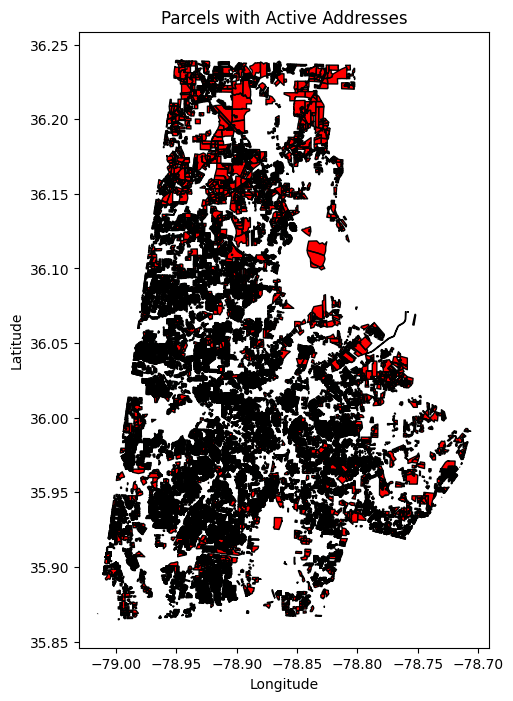

In [80]:
# Plot the parcels and addresses
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
parcels_with_counts_subset_filtered.boundary.plot(ax=ax, linewidth=1, color="black")
parcels_with_counts_subset_filtered.plot(ax=ax, marker="o", color="red", markersize=5)
plt.title("Parcels with Active Addresses")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [82]:
parcels_with_counts_subset_filtered.to_file("../data/outputs/ParcelsFinal.gdb")

/var/folders/9w/31krdsjd3x32k5n1vk0_fxd40000gn/T/ipykernel_34411/4260555969.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  parcels_with_counts_subset_filtered.to_file("../data/outputs/ParcelsFinal.gdb")


In [99]:
parcels_with_counts_subset_filtered.drop(
    columns=["Shape__Are", "Shape__Len", "geometry"]
).query("address_count > 0").sort_values(by="address_count", ascending=False).to_excel(
    "../data/outputs/residential_parcels.xlsx", index=None
)